In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandarallel import pandarallel
pandarallel.initialize(shm_size_mb = 6000, progress_bar = True)

New pandarallel memory created - Size: 6000 MB
Pandarallel will run on 8 workers


### 1. Exploring the raw data

The datasets span almost 10 years, from Q1 2010 to Q2 2019, and include over 10 million transactions. We have gathered all 37 of them into one master dataset.

In [2]:
data_raw = pd.read_csv("Data/Raw/2010Q1-2019Q2-house-disburse-full.csv")

/Users/jneagu/.virtualenvs/Main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,2,3,4,5,9,11,12,13,14,15,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The dataset contains $3.9$M transactions.

In [3]:
data_raw.shape[0]

3927475

Each dataset includes 21 attributes.

In [4]:
data_raw.columns

Index(['AMOUNT', 'BIOGUIDE_ID', 'CATEGORY', 'DATA SOURCE', 'DATE', 'DOCUMENT',
       'END DATE', 'OFFICE', 'PAYEE', 'PROGRAM', 'PURPOSE', 'QUARTER',
       'RECIP (orig.)', 'RECORDID', 'SORT SEQUENCE',
       'SORT SUBTOTAL DESCRIPTION', 'START DATE', 'TRANSACTION DATE',
       'TRANSCODE', 'TRANSCODELONG', 'YEAR'],
      dtype='object')

There are no empty attributes:

In [5]:
s = data_raw.isnull().all();
s[s.values].index

Index([], dtype='object')

#### Total Spend

In [6]:
def clean_data(x):
    if isinstance(x, str):
        return pd.to_numeric(x.replace(',', ''))
    else:
        return pd.to_numeric(x)

In [7]:
data_raw['AMOUNT'] = data_raw['AMOUNT'].apply(clean_data)

The transactions amount to a total of $\$19.75$B.

In [8]:
data_raw['AMOUNT'].sum()

19775608547.929985

#### Taxonomy

Transanctions are classified in 10 categories:

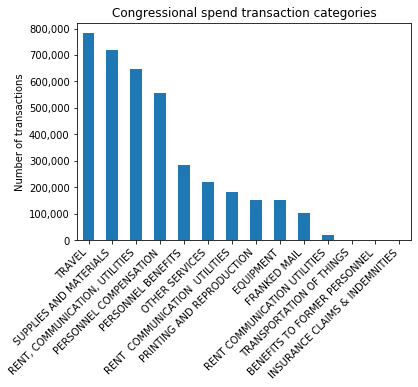

In [9]:
ax = pd.value_counts(data_raw.CATEGORY).plot.bar()
plt.xticks(rotation = 45, ha = 'right')
ax.set_title('Congressional spend transaction categories')
ax.set_ylabel('Number of transactions')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.savefig("Figures/spend_categories.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_categories.png", bbox_inches='tight', dpi = 300)

The *Purpose* attribute can serves as a sub-category. Here are the top values:

In [10]:
data_raw.PURPOSE.value_counts()

STUDENT LOANS                                       245024
PRIVATE AUTO MILEAGE                                221092
OFFICE SUPPLIES (OUTSIDE)                           197042
TELECOMSRV/EQ/TOLL CHARGE                           163591
COMMERCIAL TRANSPORTATION                           161601
                                                     ...  
CONTENT SPECIALIST                                       1
DEMOCRATIC SENIOR COUNSEL (OTHER COMPENSATION)           1
FURNITURE AND FIXTURE LESS THAN $25,000 QTY - 60         1
COMPUTER HARDW PURCH LESS THAN $25,000 QTY - 66          1
UNIFORMS QTY - 49                                        1
Name: PURPOSE, Length: 12705, dtype: int64

However, the *Purpose* attribute is too fragmented (number of unique values) to serve as an effective second level in the taxonomy.

In [11]:
data_raw.PURPOSE.nunique()

12705

In [12]:
data_raw[data_raw.CATEGORY == 'RENT, COMMUNICATION, UTILITIES'].PURPOSE.value_counts()

TELECOMSRV/EQ/TOLL CHARGE              122607
POSTAGE / COURIER / BOX RENTAL         114987
UTILITIES                               87330
DISTRICT OFFICE RENT (PRIVATE)          62342
DC TELECOM TOLLS (TRANSFER)             36721
                                        ...  
TELECOMSRV/EQ/TOLL CHARGE QTY - 287         1
TELECOMSRV/EQ/TOLL CHARGE QTY - 66          1
TELECOMSRV/EQ/TOLL CHARGE QTY - 64          1
TELECOMSRV/EQ/TOLL CHARGE QTY - 28          1
TELECOMSRV/EQ/TOLL CHARGE QTY - 6.5         1
Name: PURPOSE, Length: 85, dtype: int64

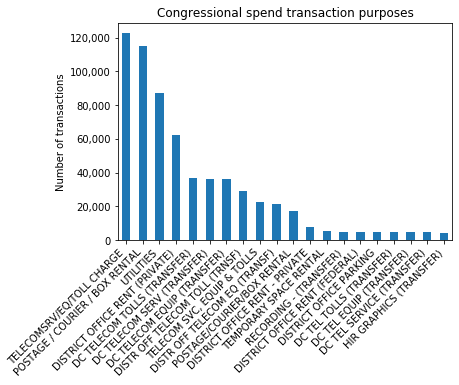

In [13]:
ax = pd.value_counts(data_raw[data_raw.CATEGORY == 'RENT, COMMUNICATION, UTILITIES'].PURPOSE)[:20].plot.bar()
plt.xticks(rotation = 45, ha = 'right')
ax.set_title('Congressional spend transaction purposes')
ax.set_ylabel('Number of transactions')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.savefig("Figures/spend_rent.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_rent.png", bbox_inches='tight', dpi = 300)

### 2. Analyzing the classified transaction data

* The Tamr transaction classification is stored in the _suggestedClassificationPathAboveThreshold_ column, in the fomat _Level_1|Level_2|...|Level_k_. We parse this into separate columns: Classification_Level_1, Classification_Level_2 etc.

In [14]:
def get_subcategory_columns(df):
    ### Add empty columns to data frame
    print('Adding empty columns...')

    df_columns = df.columns.unique()

    if 'Classification_Level_1' not in df_columns:
        df.loc[:,'Classification_Level_1'] = pd.Series()

    if 'Classification_Level_2' not in df_columns:
        df.loc[:,'Classification_Level_2'] = pd.Series()

    if 'Classification_Level_3' not in df_columns:
        df.loc[:,'Classification_Level_3'] = pd.Series()

    if 'Classification_Level_4' not in df_columns:
        df.loc[:,'Classification_Level_4'] = pd.Series()
        
    if 'Classification_Level_5' not in df_columns:
        df.loc[:,'Classification_Level_5'] = pd.Series()

    if 'Max_Category_Level' not in df_columns:
        df.loc[:,'Max_Category_Level'] = pd.Series()
    
    print('Processing...')
        
    df = df.parallel_apply(get_category_levels, axis = 1)
    
    print('Done!')

    return df

In [15]:
def get_category_levels(row):
    
    suffix = ''
    split_cat_path = row.suggestedClassificationPathAboveThreshold.split('|')
        
    for i in np.arange(len(split_cat_path)):
        row['Category_Level_' + str(i + 1)] = split_cat_path[i]
        
    row['Max_Category_Level'] = len(split_cat_path)
        
    return row

In [16]:
data_classified = pd.read_csv("Data/Classified/2010Q1-2019Q2-house-disburse-full-with_tamr_classifications.csv")

/Users/jneagu/.virtualenvs/Main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
transaction_all_processed = get_subcategory_columns(data_classified)

Adding empty columns...
Processing...


Done!


Transactions were classified up to level 5 in the taxonomy.

In [18]:
transaction_all_processed.Max_Category_Level.max()

5

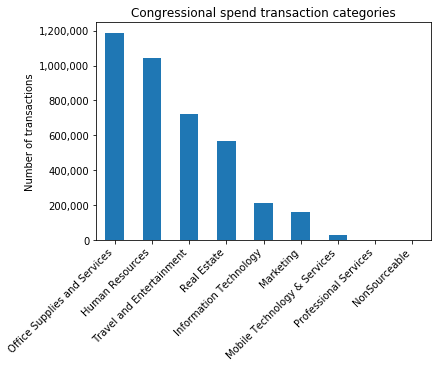

In [19]:
ax = pd.value_counts(transaction_all_processed.Category_Level_1).plot.bar()
plt.xticks(rotation = 45, ha = 'right')
ax.set_title('Congressional spend transaction categories')
ax.set_ylabel('Number of transactions')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.savefig("Figures/spend_categories_reclassified.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_categories_reclassified.png", bbox_inches='tight', dpi = 300)

#### Spend by L1 category

We compute the spend for each level 1 category.

In [20]:
transaction_all_processed.loc[:,['Category_Level_1','AMOUNT']].groupby(by = 
                                 'Category_Level_1').sum().sort_values(by = 'AMOUNT', ascending = False)

,AMOUNT
Category_Level_1,
Human Resources,5.424969e+09
Information Technology,4.071036e+09
Office Supplies and Services,1.213462e+09
NonSourceable,6.481406e+08
Real Estate,3.285710e+08
Travel and Entertainment,2.430156e+08
Marketing,8.771014e+07
Professional Services,1.019583e+07
Mobile Technology & Services,9.220344e+06


##### Human Resources spend

We can drill down into each category, and explore the spend for each subcategory.

In [21]:
transaction_all_processed[transaction_all_processed.Category_Level_1 == 'Human Resources'].loc[:,['Category_Level_2','AMOUNT']].groupby(by = 
                                 'Category_Level_2').sum().sort_values(by = 'AMOUNT', ascending = False)

,AMOUNT
Category_Level_2,
Personnel Compensation,5.350360e+09
HR Consulting,1.023679e+07
Learning,9.448653e+06


In [22]:
transaction_all_processed[transaction_all_processed.Category_Level_1 == 'Human Resources'].loc[:,['Category_Level_3','AMOUNT']].groupby(by = 
                                 'Category_Level_3').sum().sort_values(by = 'AMOUNT', ascending = False)

,AMOUNT
Category_Level_3,
Salaries,3.729399e+09
Benefits,1.549043e+09
Accommodation,9.841745e+06


\$1.5B in spend cannot be broken down further, since the relevant transaction data does include more information about how it was directed.

In [23]:
transaction_all_processed[transaction_all_processed.PURPOSE == 'PERSONNEL COMPENSATION TOTALS:'].loc[:,['Category_Level_1','AMOUNT']].groupby(by = 
                                 'Category_Level_1').sum().sort_values(by = 'AMOUNT', ascending = False)

,AMOUNT
Category_Level_1,
Human Resources,1.555606e+09


##### Office Supplies and Services spend

We can also look at how granular the spend classification is for each category.

In [24]:
transaction_all_processed[transaction_all_processed.Category_Level_1 == 'Office Supplies and Services'].loc[:,['Max_Category_Level','AMOUNT']].groupby(by = 
                                 ['Max_Category_Level']).sum()

,AMOUNT
Max_Category_Level,
1,6.541754e+07
2,7.832529e+08
3,2.899246e+08
4,7.486744e+07


#### Spend trends

Using the date attribute in the dataset, we can look at temporal trends in the spend.

In [25]:
transaction_all_processed.index = pd.to_datetime(transaction_all_processed.loc[:,'END DATE'])

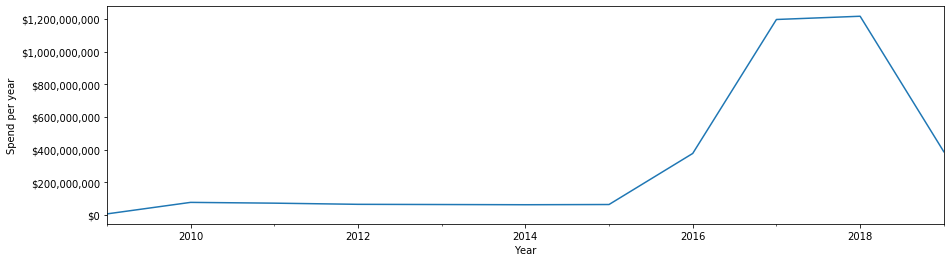

In [26]:
ax = transaction_all_processed.loc['2009-01-01':'2019-06-01'][["AMOUNT"]].resample("1y").sum().plot(figsize=(15,4))
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.get_legend().remove();
ax.set_xlabel('Year');
ax.set_ylabel('Spend per year');
plt.savefig("Figures/spend_peryear.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_peryear.png", bbox_inches='tight', dpi = 300)

We notice that more transaction spend was recorded from 2017 onwards. This indicates the possibility of missing/incomplete data before 2017. 

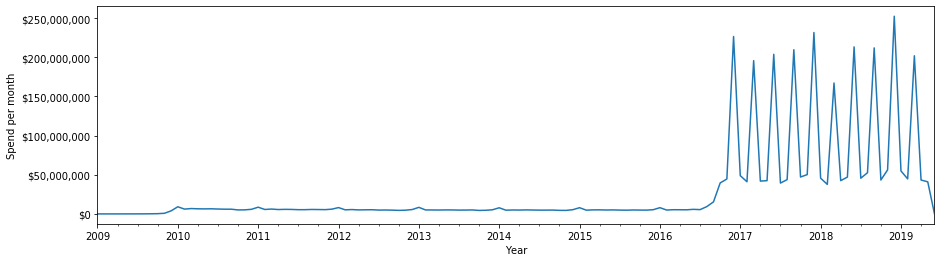

In [27]:
ax = transaction_all_processed.loc['2009-01-01':'2019-06-01'][["AMOUNT"]].resample("1m").sum().plot(figsize=(15,4))
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.get_legend().remove();
ax.set_xlabel('Year');
ax.set_ylabel('Spend per month');
plt.savefig("Figures/spend_permonth.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_permonth.png", bbox_inches='tight', dpi = 300)

After 2017, most spend is recorded at the end of a quarter (December, March, June, September).

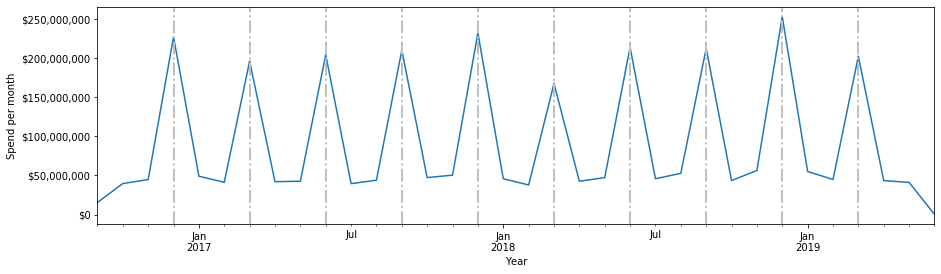

In [28]:
ax = transaction_all_processed.loc['2016-09-01':'2019-06-01'][["AMOUNT"]].resample("1m").sum().plot(figsize=(15,4))
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.get_legend().remove();
ax.set_xlabel('Year');
ax.set_ylabel('Spend per month');
ax.axvline(x = '2016-12-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2017-3-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2017-6-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2017-9-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2017-12-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2018-3-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2018-6-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2018-9-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2018-12-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2019-3-01',linewidth=2, color='.75', linestyle = '-.');
plt.savefig("Figures/spend_permonth_post2017.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_permonth_post2017.png", bbox_inches='tight', dpi = 300)

Before 2017, most spend is recorded at the beginning of the year.

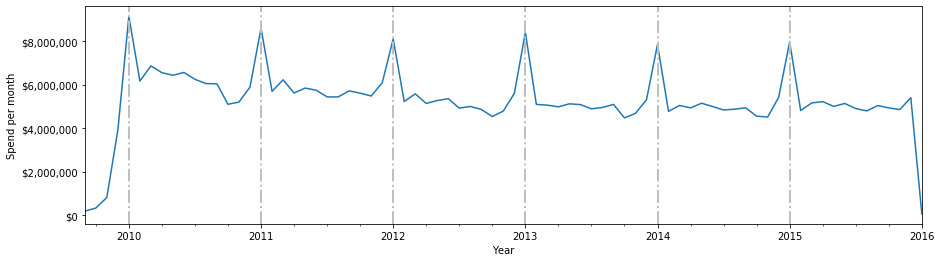

In [29]:
ax = transaction_all_processed.loc['2009-09-01':'2016-01-01'][["AMOUNT"]].resample("1m").sum().plot(figsize=(15,4))
ax.set_yticklabels(['${:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.get_legend().remove();
ax.set_xlabel('Year');
ax.set_ylabel('Spend per month');
ax.axvline(x = '2010-1-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2011-1-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2012-1-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2013-1-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2014-1-01',linewidth=2, color='.75', linestyle = '-.');
ax.axvline(x = '2015-1-01',linewidth=2, color='.75', linestyle = '-.');
plt.savefig("Figures/spend_permonth_pre2017.pdf", bbox_inches='tight', transparent = True)
plt.savefig("Figures/spend_permonth_pre2017.png", bbox_inches='tight', dpi = 300)